# Forecasting the level of average wages in Russia

In [1]:
import warnings
from itertools import product

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
%matplotlib inline

In [4]:
def invboxcox(y, lmd):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmd*y + 1) / lmd))

## 1. Visual analysis of the series

In [5]:
wag = pd.read_csv(
    filepath_or_buffer='WAG_C_M.csv', 
    sep=';', 
    index_col=['month'], 
    parse_dates=['month'], 
    dayfirst=True
)
wag.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


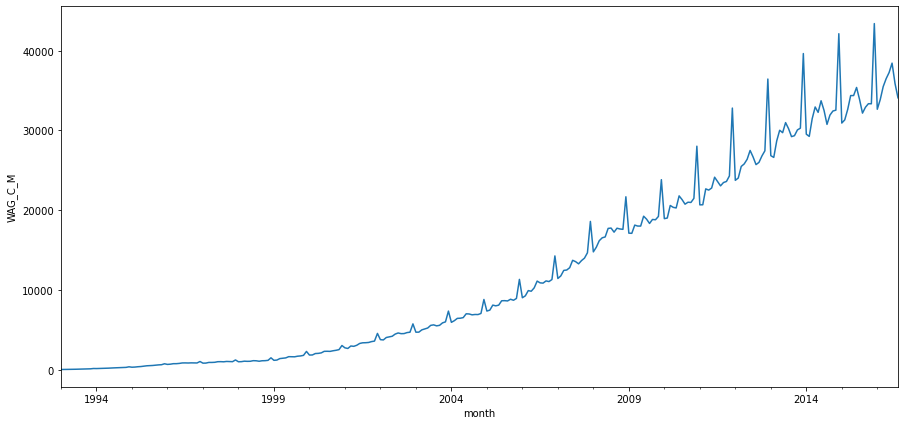

In [6]:
plt.figure(figsize=(15,7))
wag['WAG_C_M'].plot()
plt.ylabel('WAG_C_M')
plt.show()

The variance changes over time.

## 2. Variance stabilasation

In [7]:
wag['wag_box'], lmbda = stats.boxcox(wag['WAG_C_M'])
print("Optimal Box-Cox transformation parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(wag.wag_box)[1])

Optimal Box-Cox transformation parameter: 0.263202
Dickey-Fuller test: p=0.696899


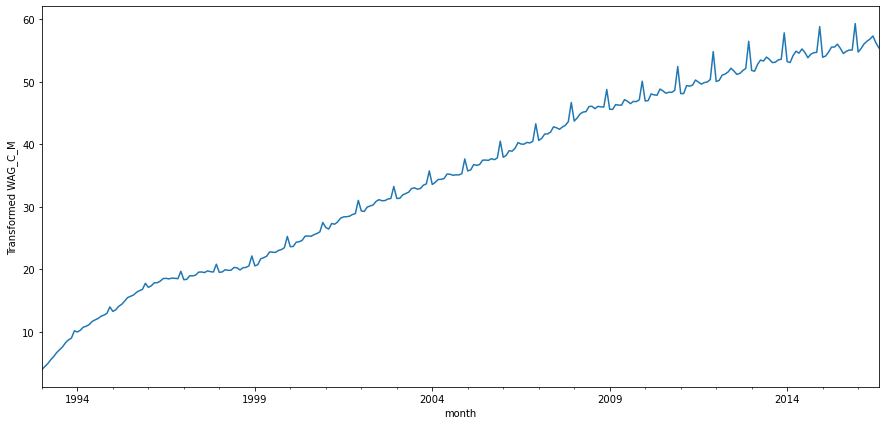

In [8]:
plt.figure(figsize=(15,7))
wag.wag_box.plot()
plt.ylabel('Transformed WAG_C_M')
plt.show()

## 3. Order of differentiation

### 3.1 Seasonal decomposition

In [9]:
wag['wag_box_diff'] = wag.wag_box - wag.wag_box.shift(12)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(wag.wag_box_diff[12:])[1])

Dickey-Fuller test: p=0.014697


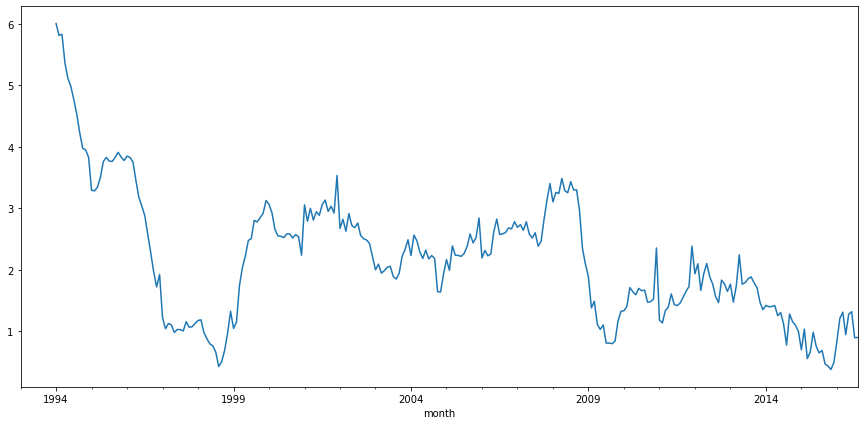

In [10]:
plt.figure(figsize=(15,7))
wag.wag_box_diff.plot()
plt.show()

The Dickey-Fuller criterion rejects the hypothesis of nonstationarity, but visually the data shows a trend.

### 3.2 Conventional differentiation

In [11]:
wag['wag_box_diff2'] = wag.wag_box_diff - wag.wag_box_diff.shift(1)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(wag.wag_box_diff2[13:])[1])

Dickey-Fuller test: p=0.000000


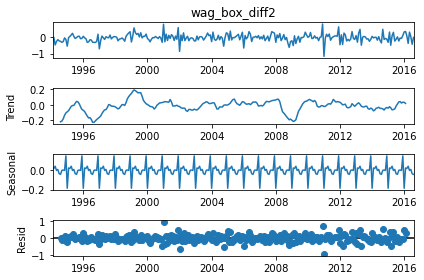

In [12]:
sm.tsa.seasonal_decompose(wag.wag_box_diff2[13:]).plot()
plt.show()

The hypothesis of nonstationarity is rejected, and visually the series looks better - there is no more trend.

## 4. Choice of initial approximations for p, q, P, Q

ACF and PACF of the resulting series:

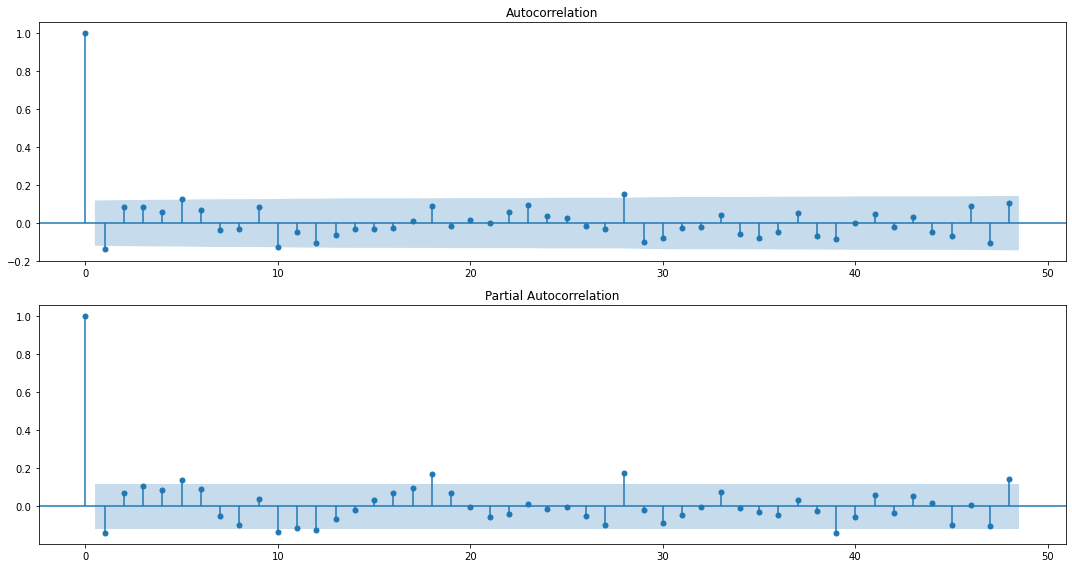

In [13]:
plt.figure(figsize=(15, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag.wag_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag.wag_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

Initial approximations: Q = 1, q = 5, P = 1, p = 5

## 5. Training and comparison of candidate models, selection of the winner

In [14]:
ps = range(6)
qs = range(6)
Ps = range(2)
Qs = range(2)
d = 1
D = 1

In [15]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

In [16]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    # try except is needed because the model is not trained on some sets of parameters
    try:
        model=sm.tsa.statespace.SARIMAX(wag.wag_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=True)
    # output the parameters on which the model is not trained and go to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 3min 59s, sys: 4.99 s, total: 4min 4s
Wall time: 2min 22s


In [17]:
result_table = pd.DataFrame(results, columns=['parameters', 'aic'])
result_table.sort_values(by='aic', ascending=True).head()

/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,parameters,aic
142,"(5, 5, 1, 0)",-25.171890
141,"(5, 5, 0, 1)",-24.451647
118,"(4, 5, 1, 0)",-24.263243
143,"(5, 5, 1, 1)",-23.538014
117,"(4, 5, 0, 1)",-23.113163


In [18]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             wag_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood                  24.586
Date:                             Fri, 12 Mar 2021   AIC                            -25.172
Time:                                     12:25:52   BIC                             18.054
Sample:                                 01-01-1993   HQIC                            -7.816
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2230      0.805     -0.277      0.782      -1.801       1.355
ar.L2          0.2388      

/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 6. Residual analysis of the constructed model

In [19]:
print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Student test: p=0.165926
Dickey–Fuller test: p=0.000000


/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


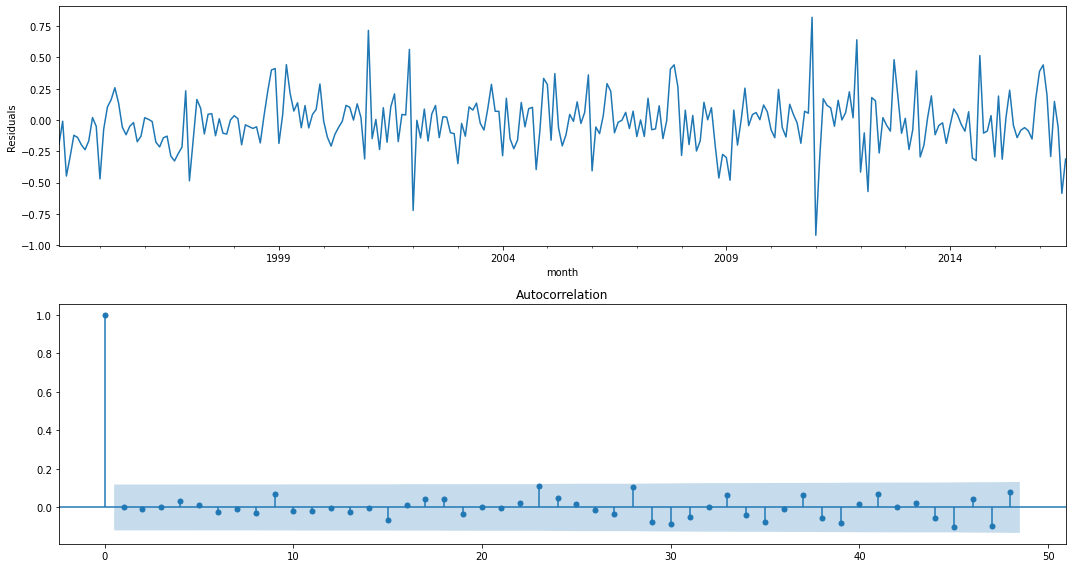

In [20]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
best_model.resid[13:].plot(ax=ax)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

plt.tight_layout()
plt.show()

The residuals are unbiased (confirmed by the Student's test), stationary (confirmed by the Dickey-Fuller test and visually), non-autocorrelated (confirmed by the Ljung-Box test and the correlogram).
Let's see how well the model describes the data:

/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


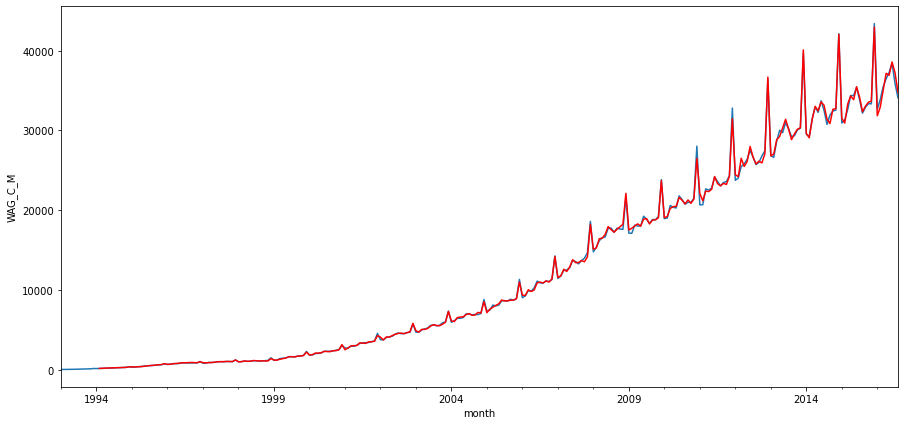

In [21]:
wag['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize=(15,7))
wag.WAG_C_M.plot()
wag.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
plt.show()

## 7. Forecasting with the final model

In [22]:
start, end = "2016-09-01", "2018-08-01"

/Users/vladislavklyuev/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
wag2 = wag[['WAG_C_M']]
date_range = pd.date_range(start=start, end=end, freq='MS')
future = pd.DataFrame(index=date_range, columns=wag2.columns)
wag2 = pd.concat([wag2, future])
wag2['forecast'] = invboxcox(best_model.predict(start=start, end=end), lmbda)

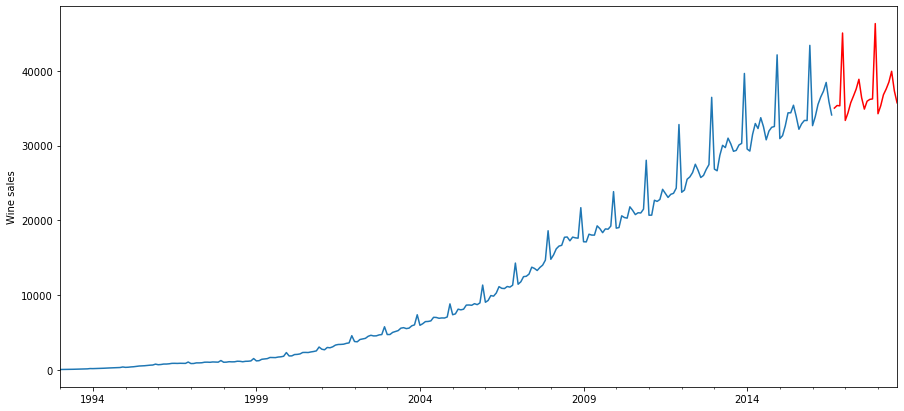

In [24]:
plt.figure(figsize=(15,7))
wag2['WAG_C_M'].plot()
wag2['forecast'].plot(color='r')
plt.ylabel('Wine sales')
plt.show()